#  Keras

In [1]:
import pandas as pd
import numpy as np
from plotly import __version__
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import glob
import os
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import warnings
warnings.simplefilter('ignore')
import tensorflow as tf
from tensorflow import keras

In [2]:
os.chdir(r"C:\Users\aivii\programsmm\FP736\corpus")

extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
combined_csv1 = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv1.to_csv( "combined_csv1.csv", index=False, encoding='utf-8-sig')

In [3]:
df = pd.read_csv('combined_csv1.csv')
df.head(10)


,Unnamed: 0,label,reviews
0,0,1,I went and saw this movie last night after bei...
1,1,1,Actor turned director Bill Paxton follows up h...
2,2,1,As a recreational golfer with some knowledge o...
3,3,1,"I saw this film in a sneak preview, and it is ..."
4,4,1,Bill Paxton has taken the true story of the 19...
5,5,1,"I saw this film on September 1st, 2005 in Indi..."
6,6,1,"Maybe I'm reading into this too much, but I wo..."
7,7,1,I felt this film did have many good qualities....
8,8,1,This movie is amazing because the fact that th...
9,9,1,"""Quitting"" may be as much about exiting a pre-..."


In [4]:
#Remove first column
df = df.drop(df.columns[0], axis=1)
df.rename(columns={'label':'sentiment'}, inplace=True)
df.head(10)

,sentiment,reviews
0,1,I went and saw this movie last night after bei...
1,1,Actor turned director Bill Paxton follows up h...
2,1,As a recreational golfer with some knowledge o...
3,1,"I saw this film in a sneak preview, and it is ..."
4,1,Bill Paxton has taken the true story of the 19...
5,1,"I saw this film on September 1st, 2005 in Indi..."
6,1,"Maybe I'm reading into this too much, but I wo..."
7,1,I felt this film did have many good qualities....
8,1,This movie is amazing because the fact that th...
9,1,"""Quitting"" may be as much about exiting a pre-..."


In [5]:
df.shape

(50000, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  50000 non-null  int64 
 1   reviews    50000 non-null  object
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


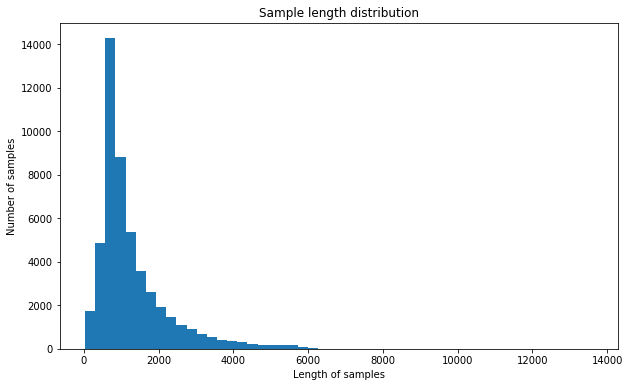

In [7]:
# average number of words per sample
plt.figure(figsize=(10, 6))
plt.hist([len(sample) for sample in list(df['reviews'])], 50)
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

In [8]:
vectorizer = CountVectorizer()

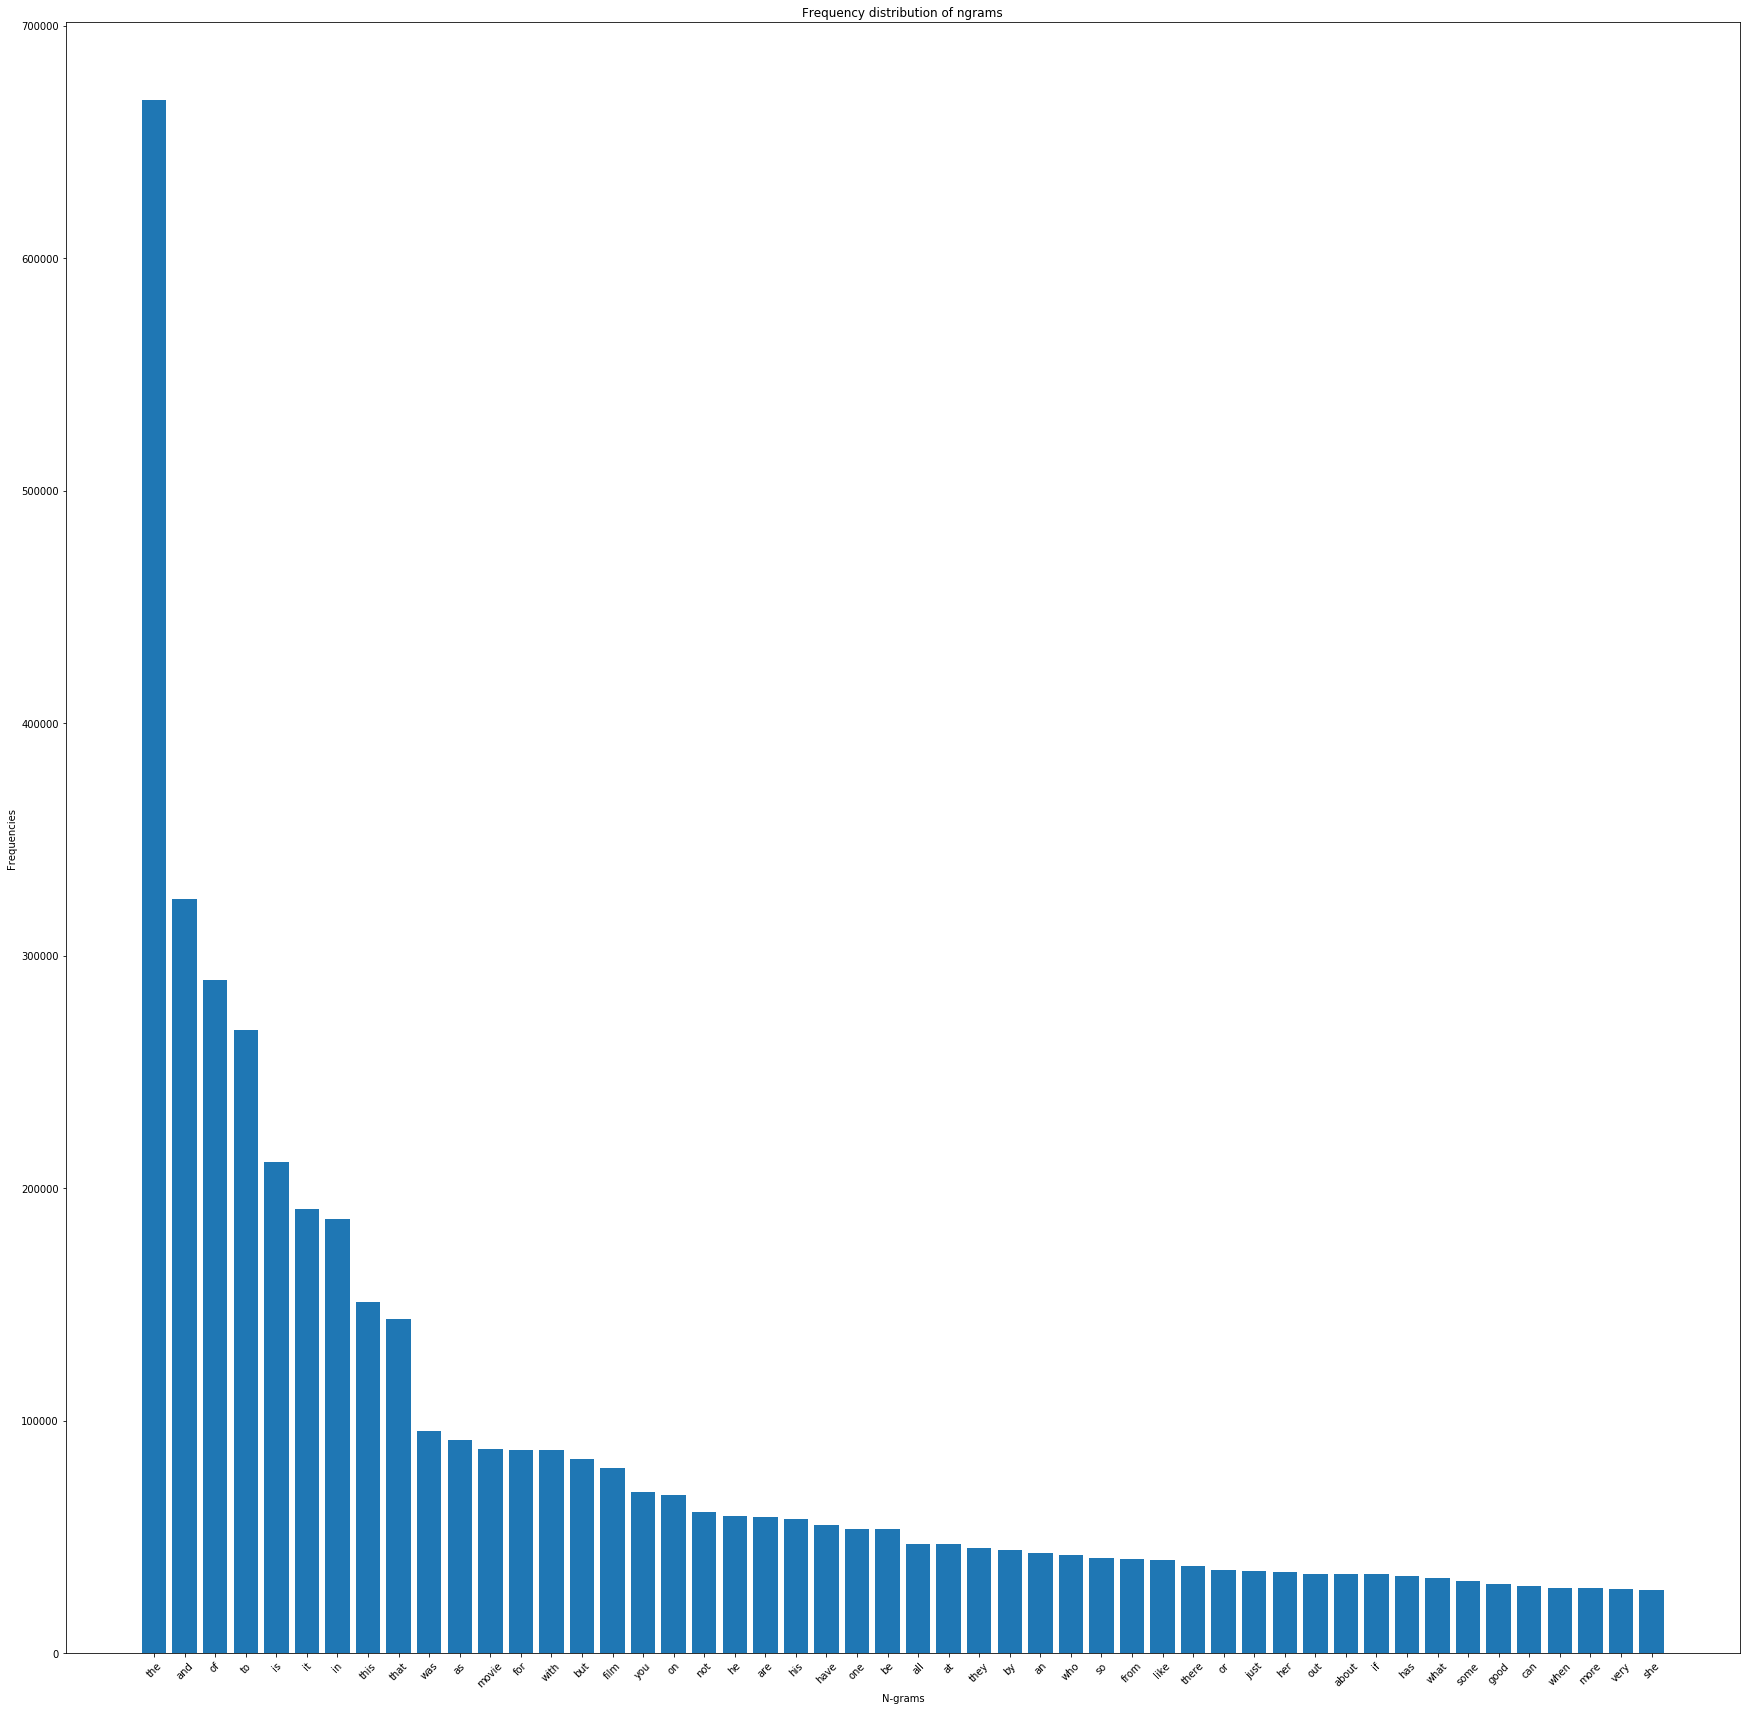

In [9]:
vect_texts = vectorizer.fit_transform(list(df['reviews']))
# ['word1', 'word2', 'word3', 'word4']

#ngrams
all_ngrams = vectorizer.get_feature_names()
num_ngrams = min(50, len(all_ngrams))
all_counts = vect_texts.sum(axis=0).tolist()[0]

all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])
ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]

idx = np.arange(num_ngrams)

# plot a frequency distribution plot of the most seen words in the corpus.
plt.figure(figsize=(30, 30))
plt.bar(idx, counts, width=0.8)
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

Highest frequency words are the stop words.

- get bigrams and unigrams from the data
- encode it using tf-idf 
- select the top 20000 features from the vector  
- discard features that occurs less than two times

In [10]:
NGRAM_RANGE = (1, 2)
TOP_K = 20000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2

def ngram_vectorize(texts, labels):
    kwargs = {
        'ngram_range' : NGRAM_RANGE,
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : TOKEN_MODE,
        'min_df' : MIN_DOC_FREQ,
    }
    # Learn Vocab from train texts and vectorize train and val sets
    tfidf_vectorizer = TfidfVectorizer(**kwargs)
    transformed_texts = tfidf_vectorizer.fit_transform(texts)
    
    # Select best k features, with feature importance measured by f_classif
    # Set k as 20000 or (if number of ngrams is less) number of ngrams   
    selector = SelectKBest(f_classif, k=min(TOP_K, transformed_texts.shape[1]))
    selector.fit(transformed_texts, labels)
    transformed_texts = selector.transform(transformed_texts).astype('float32')
    return transformed_texts
# Vectorize the data
vect_data = ngram_vectorize(df['reviews'], df['sentiment'])

In [11]:
vect_data.shape

(50000, 20000)

In [12]:
tfidf = TfidfVectorizer()
tr_texts = tfidf.fit_transform(df['reviews'])
tr_texts.shape

(50000, 101895)

#### Split data

In [13]:
from sklearn.model_selection import train_test_split

# Split data to target (y) and features (X)
X = vect_data.toarray()
y = (np.array(df['sentiment']))

# Here we split data to training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
print("Train dataset shape: {0}, \nTest dataset shape: {1}".format(X_train.shape, X_test.shape))

Train dataset shape: (40000, 20000), 
Test dataset shape: (10000, 20000)


#### Build the model

In [14]:
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

In [15]:
# function that returns the appropriate number of units and the activation for the last layer.
def get_last_layer_units_and_activation(num_classes):
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [16]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
DROPOUT_RATE = 0.2
UNITS = 64
NUM_CLASSES = 2
LAYERS = 2
input_shape = X_train.shape[1:]

op_units, op_activation = get_last_layer_units_and_activation(NUM_CLASSES)

model = keras.Sequential()
# Applies Dropout to the input
model.add(Dropout(rate=DROPOUT_RATE, input_shape=input_shape))
for _ in range(LAYERS-1):
    model.add(Dense(units=UNITS, activation='relu'))
    model.add(Dropout(rate=DROPOUT_RATE))
    
model.add(Dense(units=op_units, activation=op_activation))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1280064   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


__Compile the model__

- Loss function —This measures how accurate the model is during training. We want to minimize this function to "steer" the model in the right direction.

- Optimizer —This is how the model is updated based on the data it sees and its loss function.

- Metrics —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [17]:
LEARNING_RATE = 1e-3

# Compile model with parameters
if NUM_CLASSES == 2:
    loss = 'binary_crossentropy'
else:
    loss = 'sparse_categorical_crossentropy'
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

#### __Train the model__

In [18]:
EPOCHS = 100
BATCH_SIZE = 128

# create callback for early stopping on validation loss. If the loss does
# not decrease on two consecutive tries, stop training
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]

# Train and validate model
# To start training, call the model.fit method—the model is "fit" to the training data.
# Note that fit() will return a History object which we can use to plot training vs. validation accuracy and loss.
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 14s 344us/sample - loss: 0.4090 - acc: 0.8589 - val_loss: 0.2447 - val_acc: 0.9154
Epoch 2/100
40000/40000 [==============================] - 12s 312us/sample - loss: 0.2077 - acc: 0.9234 - val_loss: 0.1974 - val_acc: 0.9242
Epoch 3/100
40000/40000 [==============================] - 13s 320us/sample - loss: 0.1608 - acc: 0.9413 - val_loss: 0.1843 - val_acc: 0.9268
Epoch 4/100
40000/40000 [==============================] - 14s 339us/sample - loss: 0.1372 - acc: 0.9498 - val_loss: 0.1825 - val_acc: 0.9275
Epoch 5/100
40000/40000 [==============================] - 12s 293us/sample - loss: 0.1184 - acc: 0.9572 - val_loss: 0.1807 - val_acc: 0.9288
Epoch 6/100
40000/40000 [==============================] - 12s 293us/sample - loss: 0.1031 - acc: 0.9633 - val_loss: 0.1826 - val_acc: 0.9273
Epoch 7/100
40000/40000 [==============================] - 13s 314us/sample - loss: 0.0935 - acc: 

#### __Evaluate the model__

In [19]:
# Next, compare how the model performs on the test dataset:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

10000/10000 [==============================] - 1s 92us/sample - loss: 0.1872 - acc: 0.9267
Test loss: 0.18723641698360444
Test accuracy: 0.9267


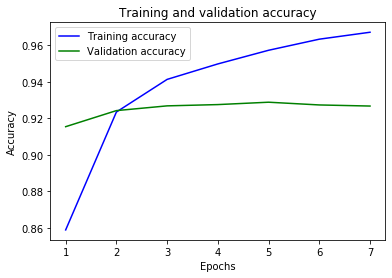

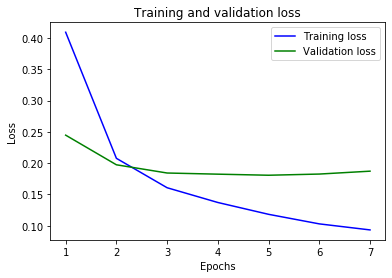

In [20]:
# plot training and validation accuracy as well as loss.
def plot_history(history):
    accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1,len(accuracy) + 1)
    
    # Plot accuracy  
    plt.figure(1)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.figure(2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history)

#### Save the model 

In [21]:
 # Save model
model.save('kera_model_dropout_nn.h5')